# **Collaborative-Hybrid-Filtering**


## **To-Do(Tasks):**
1. Tweets from twitter and applying Sentiment analysis
2. Building the Collaborative filtering-based recommender system
3. Building the Hybrid Recommender System

## **Improting Libraries**

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 13.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from numpy import count_nonzero
import progressbar as pb
import math
import os

import tweepy

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string
import re

import nltk
nltk.download('wordnet')

from scipy.sparse import rand as sprand
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Task - 1) Tweets from Twitter:**

In [ ]:
hashtags_csv = "extractedData/movies_hashtags.csv"
extracting_tweets_csv = "extractedData/tweets_text.csv"
final_movies_df_csv = 'extractedData/movieTweets.csv'

In [ ]:
ACCESS_TOKEN="YOUR-TWITTER-ACCESS-TOKEN"
ACCESS_TOKEN_SECRET="YOUR-TWITTER-ACCESS-TOKEN-SECRET"
CONSUMER_API_KEY = "YOUR-TWITTER-CONSUMER-API-KEY"
CONSUMER_API_SECRET = "YOUR-TWITTER-CONSUMER-API-SECRET"

In [ ]:
auth = tweepy.OAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True )

In [ ]:
tweet = api.home_timeline(tweet_mode='extended')
print(tweet)

[Status(_api=<tweepy.api.API object at 0x7f05af215d50>, _json={'created_at': 'Tue Aug 10 03:49:04 +0000 2021', 'id': 1424940838929453066, 'id_str': '1424940838929453066', 'full_text': '🔼 $1,737.02 - سعر أوقية الذهب مقابل الدولار في Tuesday 10 August, 2021 03:48 AM بحسب التوقيت العالمي https://t.co/PBQITKee1P', 'truncated': False, 'display_text_range': [0, 124], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/PBQITKee1P', 'expanded_url': 'http://www.BinarySnake.com/getprices/gold.cfm?ID=150903&lang=ar', 'display_url': 'BinarySnake.com/getprices/gold…', 'indices': [101, 124]}]}, 'source': '<a href="http://www.thebottlespinner.com/" rel="nofollow">thebottlegame</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 932154614530658304, 'id_str': '932154614530658304', 'name': 'Gold Price Updates الذهب اليوم', 'screen_n

In [ ]:
header = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 
          'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children_s', 
          'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

In [ ]:
df_original = pd.read_csv('movies.txt', 
                 sep="|",names=header)

In [ ]:
df_original.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_original.shape

(1682, 24)

**Creating Hashtags/Keywords from movies title**

In [ ]:
def create_hashtags(title):
  splitted_movies = title.split(" ")[:-1]
  return "#"+"".join(splitted_movies)

In [ ]:
movie_titles = df_original['movie_title'].apply(create_hashtags)
movie_titles = movie_titles.astype(str).tolist()

In [ ]:
df_original['hashtags'] = movie_titles

In [ ]:
df_original.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,hashtags
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,#ToyStory
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,#GoldenEye
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,#FourRooms
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,#GetShorty
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,#Copycat


In [ ]:
#Saving the Hashtags of movies
df_hashtags = pd.DataFrame(movie_titles, columns=['Keyword'])
df_hashtags.to_csv(hashtags_csv,
                   header='column_names',index=False)

**Function to remove the already fetched tweets**

In [ ]:
def removeExtractedData():
    df_hashtags = pd.read_csv(hashtags_csv,index_col=0)
    df_scrapped_tweets = pd.read_csv(extracting_tweets_csv)
    list_ = df_scrapped_tweets['keyword'].tolist()
    for i in list_:
        try:
          #print(i)
          df_hashtags = df_hashtags.drop(i, axis=0)#, inplace=True)
        except Exception as e:
            print('', end='')
    return df_hashtags

**Function to Scrap tweets**

In [ ]:
def scraptweets():
    last_index = 0
    numTweets = 10

    df_hashtags = pd.read_csv(hashtags_csv)
    
    df_txts = pd.DataFrame(columns =['keyword','tweets'])

    if os.path.isfile(saving_last_movie_index):
      file = open(saving_last_movie_index, 'r')
      lines = file.readlines()
      last_index = int(lines[-1])

    df_hashtags = removeExtractedData()
    df_hashtags.reset_index(inplace=True)

    for indices, value in df_hashtags.iterrows():
      print('===========================================')
      print('Scrapping tweets of keyword:',value['Keyword'])
      try:
        tweets = tweepy.Cursor(api.search, q=value['Keyword'], lang="en"#, since='2020-08-05'
                              , tweet_mode='extended').items(25)
        print('In Progress...')
        tweets_ = ""
        tweets_count=0
        for tweet in tweets:
          keyword =value['Keyword']
          try:
            text = tweet.retweeted_status.full_text
            tweets_ = tweets_+" "+text
          except:  
            text = tweet.full_text
            tweets_ = tweets_+" "+text
          tweets_count+=1

        saving_txt_tweets =  [value['Keyword'], tweets_]
        df_txts.loc[len(df_txts)] = saving_txt_tweets

        if not os.path.isfile(extracting_tweets_csv):
          df_txts.to_csv(extracting_tweets_csv, header='column_names',index=False)
        else: 
          df_txts.to_csv(extracting_tweets_csv, mode='a', header=False,index=False)
        last_index = indices
        print(tweets_count,'total tweets of',value['Keyword'],'keyword stored successfully...')
      except Exception as e:
        print("Somthing went wrong, please try again later.")
        print("Last Extracted Movie Id:"+str(last_index))
        print("See what went wrong?", e)

In [ ]:
scraptweets()

**Saving the scrapped tweets**

In [ ]:
scrapped_tweets_df.to_csv(extracting_tweets_csv, header='column_names',index=False)

In [ ]:
scrapped_tweets_df = pd.read_csv(extracting_tweets_csv)#,index_col='keyword')
scrapped_tweets_df.drop_duplicates(inplace=True)
scrapped_tweets_df

,keyword,tweets
0,#ToyStory,The little monsters in the anime story are so...
1,#GoldenEye,#GoldenEye Multiplayer Daily Totals \n\n0 Use...
2,#FourRooms,@paperbuddha #FourRooms is one of it 🤘
3,#GetShorty,#Mini not quite #quirky enough? How about a #...
4,#Copycat,"“Hey, Ernie! You think there’s any truth to ..."
...,...,...
1654,#Mat'isyn,NaN
1655,#B.Monkey,"@spsrei his airspeed is awful, his hurtbox is..."
1656,#YouSoCrazy,NaN
1657,#ScreamofStone(SchreiausStein),NaN


**Merging scrapped tweets to Orginal DataFrame**

In [ ]:
def mappingComments(scrapped_df_, original_df_):
  original_df_['Tweets'] = pd.Series(dtype='str')              

  for indices, value in original_df_.iterrows():
    index = scrapped_df_[scrapped_df_['keyword']==value['hashtags']].index.values
    original_df_.at[indices, 'Tweets'] = " ".join(str(e) for e in scrapped_df_.iloc[index]['tweets'].values)
  return original_df_

In [ ]:
merged_df = mappingComments(scrapped_tweets_df, df_original)
merged_df.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,Tweets,hashtags
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The little monsters in the anime story are so...,#ToyStory
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,#GoldenEye Multiplayer Daily Totals \n\n0 Use...,#GoldenEye
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,@paperbuddha #FourRooms is one of it 🤘,#FourRooms
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,#Mini not quite #quirky enough? How about a #...,#GetShorty
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,"“Hey, Ernie! You think there’s any truth to ...",#Copycat


**Saving merged tweets**

In [ ]:
merged_df.to_csv(final_movies_df_csv,
                 header='column_names',index=False)

**Sentiment Analysis on scrapped movie tweets**

In [ ]:
df_original = pd.read_csv(final_movies_df_csv) 

In [ ]:
df_original

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,Tweets,hashtags,Sentiment_Score,Sentiment
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The little monsters in the anime story are so...,#ToyStory,1.00,Positive
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,#GoldenEye Multiplayer Daily Totals \n\n0 Use...,#GoldenEye,1.00,Positive
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,@paperbuddha #FourRooms is one of it 🤘,#FourRooms,0.00,Neutral
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,#Mini not quite #quirky enough? How about a #...,#GetShorty,0.49,Positive
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,"“Hey, Ernie! You think there’s any truth to ...",#Copycat,1.00,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,#Mat'isyn,0.00,Neutral
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,"@spsrei his airspeed is awful, his hurtbox is...",#B.Monkey,0.93,Positive
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,Thanks Rajamani sir for offering us the order...,#SlidingDoors,1.00,Positive
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,#YouSoCrazy,0.00,Neutral


In [ ]:
sid_analyzer = SentimentIntensityAnalyzer()
dictionaryObject = df_original['Tweets'].to_dict()

In [ ]:
dictionaryObject

In [ ]:
count = 0
list = []
for i in dictionaryObject:
  obj = str(dictionaryObject[i]).strip()
  list.append(obj)

In [ ]:
print('Inbuilt Punctuations:',string.punctuation)
custom_punctuation = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'
print('Custom Punctuations:',custom_punctuation)

Inbuilt Punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Custom Punctuations: "#$%&'()*+,-./:;<=>@[\]^_`{|}~


In [ ]:
def comment_Cleaning(list, custom_punctuation):
    #translated_txt =[translator.translate(x,lang_tgt='en') for x in list]
    
    # Lowering text
    list_lower = [x.lower() for x in list]
    
    #Remvoing punctuations
    puntuation_filtered_txt = [txt.translate(str.maketrans(custom_punctuation, ' '*len(custom_punctuation))) for txt in list_lower]
    
    #Removing extra spaces
    pattern_1 = "\s+"
    cleaned_txt=[re.sub(pattern_1," ",x) for x in puntuation_filtered_txt]
    
    #Handlling unnecessary letter repetition
    pattern_2=re.compile(r"(.)\1{2,}")
    cleaned_txt=[pattern_2.sub(r"\1\1",x) for x in cleaned_txt]
    
    return cleaned_txt   

In [ ]:
cleaned_comments = comment_Cleaning(list, custom_punctuation)

In [ ]:
def sentiment_scores(sentence):
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    score = round(sentiment_dict['compound'], 2)
    return score

In [ ]:
def sentiments(score):
    if score >= 0.05 :
        return 'Positive'#f'Positive: {score}'
 
    elif score <= - 0.05 :
        return 'Negative'#f'Negative: {score}'
 
    else :
        return 'Neutral'#f'Neutral: {score}'

In [ ]:
sentiment = [sentiment_scores(comments) for comments in cleaned_comments]

In [ ]:
print('Total list of comments:',len(list))
print('Total list of cleaned comments:',len(cleaned_comments))
print('Total list of comments sentiment:',len(sentiment))
#print('Total list of comments sentiment score:',len(score))

Total list of comments: 1682
Total list of cleaned comments: 1682
Total list of comments sentiment: 1682


In [ ]:
df_original['Sentiment_Score'] = sentiment
df_original['Sentiment'] = df_original['Sentiment_Score'].apply(lambda x: sentiments(x))

In [ ]:
df_original.sample(5)

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,Tweets,hashtags,Sentiment_Score,Sentiment
1104,1105,Firestorm (1998),09-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,@IndiaToday It'll Be Gruesome As Rains Will W...,#Firestorm,-1.00,Negative
817,818,Girl 6 (1996),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Girl%206%20(1...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,#Girl6,0.00,Neutral
1416,1417,"Turning, The (1992)",02-May-1997,NaN,http://us.imdb.com/M/title-exact?Turning%2C%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,@pabiedu1 @SecBlinken @RepGregoryMeeks @Saman...,"#Turning,The",1.00,Positive
198,199,"Bridge on the River Kwai, The (1957)",01-Jan-1957,NaN,http://us.imdb.com/M/title-exact?Bridge%20on%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,"If the guest isn't singing ""Oh What A Beautif...","#BridgeontheRiverKwai,The",0.91,Positive
332,333,"Game, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Game%2C+The+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,RT @StupidGamer18: GENSHIN IMPACT TREATMENT O...,"#Game,The",1.00,Positive


In [ ]:
df_original.shape

(1682, 28)

In [ ]:
df_original.to_csv(final_movies_df_csv,
                 header='column_names',index=False)

In [ ]:
df_original.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,Tweets,hashtags,Sentiment_Score,Sentiment
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The little monsters in the anime story are so...,#ToyStory,1.00,Positive
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,#GoldenEye Multiplayer Daily Totals \n\n0 Use...,#GoldenEye,1.00,Positive
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,@paperbuddha #FourRooms is one of it 🤘,#FourRooms,0.00,Neutral
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,#Mini not quite #quirky enough? How about a #...,#GetShorty,0.49,Positive
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,"“Hey, Ernie! You think there’s any truth to ...",#Copycat,1.00,Positive


In [ ]:
top_10_positive = df_original.sort_values(by=['Sentiment_Score'], ascending=False).head(10)

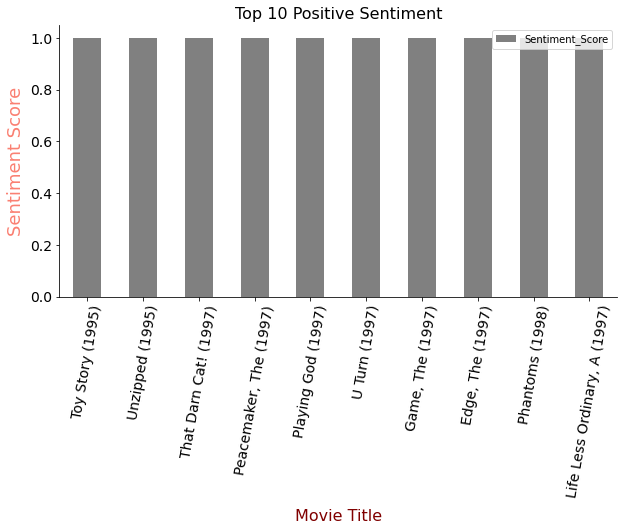

In [ ]:
ax = top_10_positive.plot.bar(x='movie_title', y='Sentiment_Score', rot=0, 
                 figsize=(10, 5), legend=True, fontsize=14, color ='grey')
ax.set_xticklabels(labels=top_10_positive['movie_title'],rotation=80)
ax.set_xlabel("Movie Title", fontsize=16, labelpad=10, color='maroon')
ax.set_ylabel("Sentiment Score", fontsize=18, labelpad=5, color='salmon')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title("Top 10 Positive Sentiment", fontsize=16)
plt.show()

In [ ]:
results_df = pd.DataFrame(columns=['System','Accuracy','MSE','RMSE','Precision','Recall','F1-Score'])

## **Task - 2) Building the Collaborative filtering-based recommender system**

In [ ]:
with open("ratings.txt", 'r', encoding='cp1252') as file:
  info = file.read().rstrip('\n')
info

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data = info.split('\n')

dummy = np.zeros((1683, 944), dtype=int) # column, rows
user_ = []
movie_ = []

df = pd.DataFrame(dummy)
df.head()
for i in range(len(data)):
  obs = data[i].split('\t')
  user_.append(int(obs[0]))
  movie_.append(int(obs[1]))
  df.iloc[int(obs[1]), int(obs[0])]=int(obs[2])

In [ ]:
print('Last user ID:',max(user_))
print('Last Movie ID:',max(movie_))

Last user ID: 943
Last Movie ID: 1682


**Rows = movie ID & Columns = User ID.**

In [ ]:
df.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
689,0,0,0,0,0,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,3,0
1311,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
982,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
570,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1
1604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1642,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
937,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
159,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
744,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,4,5,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
505,0,0,0,0,0,0,4,3,0,0,4,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## To-Do

Calculate the sparsity and the density of the matrix

In [ ]:
x = df.to_numpy()

**i. Sparsity & Density of matrix**
Sparse: Matrices that contain mostly zero values are called sparse,   

Density: Distinct from matrices where most of the values are non-zero, called dense

In [ ]:
non_zero = np.count_nonzero(x)
total_val = np.product(x.shape)

print('Non-Zeros: ',non_zero)
print('Total values',total_val)

Non-Zeros:  100000
Total values 1588752


In [ ]:
#Calculate sparsity
sparsity = (total_val - non_zero) / total_val

#Calculate Density
density = non_zero / total_val

#sparsity = 1.0 -(count_nonzero(x) /float(x.size))
print('Sparsity:',sparsity.round(3))
print('Density:',density.round(3))

Sparsity: 0.937
Density: 0.063


**ii. Matrix Factorization**

In [ ]:
def matrix_factorization(R, P, Q, K, steps, alpha=0.0002, beta=0.02):
    Q = Q.T
    print(type(steps),steps)
    for step in pb.progressbar(range(steps)):
        for i in range(len(R)): #Iterate Rows of R: i.e: 1683
            for j in range(len(R[i])): #Iterate Columns of R: i.e: 944
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K): # K represents column of P & Rows of Q
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k]) # Gradient descent formula.
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j]) # Gradient descent formula.
        
        #Estimate for how well the prediction matrix is doing
        eR = np.dot(P,Q)
        e = 0
        counter = 0
        for i in range(len(R)): #Iterate Rows of R: i.e: 1683
            for j in range(len(R[i])): #Iterate Columns of R: i.e: 944
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    counter+=1
                    for k in range(K):  # K represents column of P & Rows of Q
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
                        counter+=1

        e=e/counter # Here, e is MSE
        rmse = math.sqrt(e)
       
        loss_mf.append(e)
        rmse_mf_list.append(rmse)
        
        mf_mse = e
        mf_rmse = rmse

        print(' STEP ===>',step,'; MSE:',round(e,5), '; RMSE:',round(rmse,5))
        if e < 0.01:
            break
    return P, Q.T


In [ ]:
R = np.array(df)
N = len(R) # Rows
M = len(R[0]) # Columns
K = 50 # Random
P = np.random.rand(N,K)#6, size=(N,K))
Q = np.random.rand(M,K)#6, size=(M,K))
print(N, M)
print('P:',P.shape)
print('Q:',Q.shape)

1683 944
P: (1683, 50)
Q: (944, 50)


In [ ]:
loss_mf=[]
rmse_mf_list = []
predictions_mf = []
true_value_mf = []
mf_mse = 0
mf_rmse = 0

nP, nQ = matrix_factorization(R, P, Q, K, 500)
nR = np.dot(nP, nQ.T)

N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

<class 'int'> 500


  0% (1 of 500) |                        | Elapsed Time: 0:00:44 ETA:   6:12:24

 STEP ===> 0 ; MSE: 0.23298 ; RMSE: 0.48268


  0% (2 of 500) |                        | Elapsed Time: 0:01:30 ETA:   6:16:26

 STEP ===> 1 ; MSE: 0.12624 ; RMSE: 0.35531


  0% (3 of 500) |                        | Elapsed Time: 0:02:14 ETA:   6:11:14

 STEP ===> 2 ; MSE: 0.09253 ; RMSE: 0.30419


  0% (4 of 500) |                        | Elapsed Time: 0:03:00 ETA:   6:15:29

 STEP ===> 3 ; MSE: 0.07632 ; RMSE: 0.27627


  1% (5 of 500) |                        | Elapsed Time: 0:03:44 ETA:   6:07:48

 STEP ===> 4 ; MSE: 0.06664 ; RMSE: 0.25814


  1% (6 of 500) |                        | Elapsed Time: 0:04:29 ETA:   6:07:38

 STEP ===> 5 ; MSE: 0.06005 ; RMSE: 0.24504


  1% (7 of 500) |                        | Elapsed Time: 0:05:13 ETA:   6:04:41

 STEP ===> 6 ; MSE: 0.05518 ; RMSE: 0.23491


  1% (8 of 500) |                        | Elapsed Time: 0:05:59 ETA:   6:13:45

 STEP ===> 7 ; MSE: 0.05139 ; RMSE: 0.22669


  1% (9 of 500) |                        | Elapsed Time: 0:06:45 ETA:   6:15:01

 STEP ===> 8 ; MSE: 0.04832 ; RMSE: 0.21982


  2% (10 of 500) |                       | Elapsed Time: 0:07:30 ETA:   6:04:47

 STEP ===> 9 ; MSE: 0.04576 ; RMSE: 0.21392


  2% (11 of 500) |                       | Elapsed Time: 0:08:14 ETA:   6:02:12

 STEP ===> 10 ; MSE: 0.04358 ; RMSE: 0.20877


  2% (12 of 500) |                       | Elapsed Time: 0:08:59 ETA:   6:01:53

 STEP ===> 11 ; MSE: 0.0417 ; RMSE: 0.20421


  2% (13 of 500) |                       | Elapsed Time: 0:09:43 ETA:   5:58:26

 STEP ===> 12 ; MSE: 0.04005 ; RMSE: 0.20012


  2% (14 of 500) |                       | Elapsed Time: 0:10:27 ETA:   5:57:57

 STEP ===> 13 ; MSE: 0.03858 ; RMSE: 0.19643


  3% (15 of 500) |                       | Elapsed Time: 0:11:12 ETA:   6:02:16

 STEP ===> 14 ; MSE: 0.03727 ; RMSE: 0.19307


  3% (16 of 500) |                       | Elapsed Time: 0:11:56 ETA:   5:56:08

 STEP ===> 15 ; MSE: 0.03609 ; RMSE: 0.18999


  3% (17 of 500) |                       | Elapsed Time: 0:12:41 ETA:   6:01:38

 STEP ===> 16 ; MSE: 0.03502 ; RMSE: 0.18715


  3% (18 of 500) |                       | Elapsed Time: 0:13:25 ETA:   5:52:12

 STEP ===> 17 ; MSE: 0.03405 ; RMSE: 0.18452


  3% (19 of 500) |                       | Elapsed Time: 0:14:09 ETA:   5:57:19

 STEP ===> 18 ; MSE: 0.03315 ; RMSE: 0.18207


  4% (20 of 500) |                       | Elapsed Time: 0:14:55 ETA:   6:03:19

 STEP ===> 19 ; MSE: 0.03233 ; RMSE: 0.17979


  4% (21 of 500) |                       | Elapsed Time: 0:15:40 ETA:   5:58:42

 STEP ===> 20 ; MSE: 0.03156 ; RMSE: 0.17766


  4% (22 of 500) |#                      | Elapsed Time: 0:16:23 ETA:   5:49:49

 STEP ===> 21 ; MSE: 0.03085 ; RMSE: 0.17565


  4% (23 of 500) |#                      | Elapsed Time: 0:17:07 ETA:   5:49:45

 STEP ===> 22 ; MSE: 0.03019 ; RMSE: 0.17377


  4% (24 of 500) |#                      | Elapsed Time: 0:17:52 ETA:   5:53:50

 STEP ===> 23 ; MSE: 0.02958 ; RMSE: 0.17199


  5% (25 of 500) |#                      | Elapsed Time: 0:18:37 ETA:   5:52:27

 STEP ===> 24 ; MSE: 0.029 ; RMSE: 0.1703


  5% (26 of 500) |#                      | Elapsed Time: 0:19:21 ETA:   5:48:24

 STEP ===> 25 ; MSE: 0.02846 ; RMSE: 0.16871


  5% (27 of 500) |#                      | Elapsed Time: 0:20:05 ETA:   5:46:53

 STEP ===> 26 ; MSE: 0.02795 ; RMSE: 0.1672


  5% (28 of 500) |#                      | Elapsed Time: 0:20:49 ETA:   5:45:16

 STEP ===> 27 ; MSE: 0.02748 ; RMSE: 0.16576


  5% (29 of 500) |#                      | Elapsed Time: 0:21:33 ETA:   5:46:03

 STEP ===> 28 ; MSE: 0.02702 ; RMSE: 0.16439


  6% (30 of 500) |#                      | Elapsed Time: 0:22:16 ETA:   5:40:47

 STEP ===> 29 ; MSE: 0.0266 ; RMSE: 0.16308


  6% (31 of 500) |#                      | Elapsed Time: 0:23:00 ETA:   5:41:19

 STEP ===> 30 ; MSE: 0.02619 ; RMSE: 0.16184


  6% (32 of 500) |#                      | Elapsed Time: 0:23:45 ETA:   5:49:06

 STEP ===> 31 ; MSE: 0.02581 ; RMSE: 0.16065


  6% (33 of 500) |#                      | Elapsed Time: 0:24:29 ETA:   5:43:43

 STEP ===> 32 ; MSE: 0.02544 ; RMSE: 0.15951


  6% (34 of 500) |#                      | Elapsed Time: 0:25:12 ETA:   5:37:09

 STEP ===> 33 ; MSE: 0.0251 ; RMSE: 0.15842


  7% (35 of 500) |#                      | Elapsed Time: 0:25:56 ETA:   5:42:11

 STEP ===> 34 ; MSE: 0.02476 ; RMSE: 0.15737


  7% (36 of 500) |#                      | Elapsed Time: 0:26:40 ETA:   5:40:34

 STEP ===> 35 ; MSE: 0.02445 ; RMSE: 0.15636


  7% (37 of 500) |#                      | Elapsed Time: 0:27:23 ETA:   5:26:27

 STEP ===> 36 ; MSE: 0.02415 ; RMSE: 0.1554


  7% (38 of 500) |#                      | Elapsed Time: 0:28:07 ETA:   5:44:47

 STEP ===> 37 ; MSE: 0.02386 ; RMSE: 0.15447


  7% (39 of 500) |#                      | Elapsed Time: 0:28:52 ETA:   5:39:19

 STEP ===> 38 ; MSE: 0.02359 ; RMSE: 0.15358


  8% (40 of 500) |#                      | Elapsed Time: 0:29:36 ETA:   5:38:49

 STEP ===> 39 ; MSE: 0.02332 ; RMSE: 0.15272


  8% (41 of 500) |#                      | Elapsed Time: 0:30:20 ETA:   5:38:05

 STEP ===> 40 ; MSE: 0.02307 ; RMSE: 0.15189


  8% (42 of 500) |#                      | Elapsed Time: 0:31:04 ETA:   5:35:59

 STEP ===> 41 ; MSE: 0.02283 ; RMSE: 0.15109


  8% (43 of 500) |#                      | Elapsed Time: 0:31:49 ETA:   5:39:09

 STEP ===> 42 ; MSE: 0.02259 ; RMSE: 0.15031


  8% (44 of 500) |##                     | Elapsed Time: 0:32:32 ETA:   5:28:18

 STEP ===> 43 ; MSE: 0.02237 ; RMSE: 0.14957


  9% (45 of 500) |##                     | Elapsed Time: 0:33:16 ETA:   5:36:39

 STEP ===> 44 ; MSE: 0.02216 ; RMSE: 0.14885


  9% (46 of 500) |##                     | Elapsed Time: 0:34:00 ETA:   5:34:16

 STEP ===> 45 ; MSE: 0.02195 ; RMSE: 0.14815


  9% (47 of 500) |##                     | Elapsed Time: 0:34:46 ETA:   5:42:06

 STEP ===> 46 ; MSE: 0.02175 ; RMSE: 0.14747


  9% (48 of 500) |##                     | Elapsed Time: 0:35:30 ETA:   5:31:36

 STEP ===> 47 ; MSE: 0.02156 ; RMSE: 0.14682


  9% (49 of 500) |##                     | Elapsed Time: 0:36:14 ETA:   5:31:15

 STEP ===> 48 ; MSE: 0.02137 ; RMSE: 0.14619


 10% (50 of 500) |##                     | Elapsed Time: 0:36:59 ETA:   5:41:38

 STEP ===> 49 ; MSE: 0.02119 ; RMSE: 0.14557


 10% (51 of 500) |##                     | Elapsed Time: 0:37:43 ETA:   5:26:18

 STEP ===> 50 ; MSE: 0.02102 ; RMSE: 0.14498


 10% (52 of 500) |##                     | Elapsed Time: 0:38:26 ETA:   5:25:40

 STEP ===> 51 ; MSE: 0.02085 ; RMSE: 0.1444


 10% (53 of 500) |##                     | Elapsed Time: 0:39:11 ETA:   5:29:55

 STEP ===> 52 ; MSE: 0.02069 ; RMSE: 0.14384


 10% (54 of 500) |##                     | Elapsed Time: 0:39:54 ETA:   5:21:27

 STEP ===> 53 ; MSE: 0.02053 ; RMSE: 0.1433


 11% (55 of 500) |##                     | Elapsed Time: 0:40:38 ETA:   5:27:05

 STEP ===> 54 ; MSE: 0.02038 ; RMSE: 0.14277


 11% (56 of 500) |##                     | Elapsed Time: 0:41:22 ETA:   5:23:33

 STEP ===> 55 ; MSE: 0.02024 ; RMSE: 0.14225


 11% (57 of 500) |##                     | Elapsed Time: 0:42:06 ETA:   5:24:51

 STEP ===> 56 ; MSE: 0.02009 ; RMSE: 0.14175


 11% (58 of 500) |##                     | Elapsed Time: 0:42:50 ETA:   5:23:56

 STEP ===> 57 ; MSE: 0.01996 ; RMSE: 0.14126


 11% (59 of 500) |##                     | Elapsed Time: 0:43:33 ETA:   5:19:07

 STEP ===> 58 ; MSE: 0.01982 ; RMSE: 0.14079


 12% (60 of 500) |##                     | Elapsed Time: 0:44:18 ETA:   5:25:27

 STEP ===> 59 ; MSE: 0.01969 ; RMSE: 0.14032


 12% (61 of 500) |##                     | Elapsed Time: 0:45:00 ETA:   5:09:45

 STEP ===> 60 ; MSE: 0.01956 ; RMSE: 0.13987


 12% (62 of 500) |##                     | Elapsed Time: 0:45:44 ETA:   5:18:31

 STEP ===> 61 ; MSE: 0.01944 ; RMSE: 0.13943


 12% (63 of 500) |##                     | Elapsed Time: 0:46:26 ETA:   5:12:19

 STEP ===> 62 ; MSE: 0.01932 ; RMSE: 0.139


 12% (64 of 500) |##                     | Elapsed Time: 0:47:11 ETA:   5:21:54

 STEP ===> 63 ; MSE: 0.01921 ; RMSE: 0.13859


 13% (65 of 500) |##                     | Elapsed Time: 0:47:55 ETA:   5:18:53

 STEP ===> 64 ; MSE: 0.01909 ; RMSE: 0.13818


 13% (66 of 500) |###                    | Elapsed Time: 0:48:38 ETA:   5:12:01

 STEP ===> 65 ; MSE: 0.01898 ; RMSE: 0.13778


 13% (67 of 500) |###                    | Elapsed Time: 0:49:20 ETA:   5:06:17

 STEP ===> 66 ; MSE: 0.01888 ; RMSE: 0.13739


 13% (68 of 500) |###                    | Elapsed Time: 0:50:04 ETA:   5:16:58

 STEP ===> 67 ; MSE: 0.01877 ; RMSE: 0.13701


 13% (69 of 500) |###                    | Elapsed Time: 0:50:48 ETA:   5:16:26

 STEP ===> 68 ; MSE: 0.01867 ; RMSE: 0.13663


 14% (70 of 500) |###                    | Elapsed Time: 0:51:31 ETA:   5:08:19

 STEP ===> 69 ; MSE: 0.01857 ; RMSE: 0.13627


 14% (71 of 500) |###                    | Elapsed Time: 0:52:15 ETA:   5:09:44

 STEP ===> 70 ; MSE: 0.01847 ; RMSE: 0.13591


 14% (72 of 500) |###                    | Elapsed Time: 0:52:58 ETA:   5:09:29

 STEP ===> 71 ; MSE: 0.01838 ; RMSE: 0.13556


 14% (73 of 500) |###                    | Elapsed Time: 0:53:41 ETA:   5:08:19

 STEP ===> 72 ; MSE: 0.01828 ; RMSE: 0.13521


 14% (74 of 500) |###                    | Elapsed Time: 0:54:25 ETA:   5:06:08

 STEP ===> 73 ; MSE: 0.01819 ; RMSE: 0.13488


 15% (75 of 500) |###                    | Elapsed Time: 0:55:09 ETA:   5:17:23

 STEP ===> 74 ; MSE: 0.0181 ; RMSE: 0.13455


 15% (76 of 500) |###                    | Elapsed Time: 0:55:53 ETA:   5:05:04

 STEP ===> 75 ; MSE: 0.01802 ; RMSE: 0.13422


 15% (77 of 500) |###                    | Elapsed Time: 0:56:37 ETA:   5:11:34

 STEP ===> 76 ; MSE: 0.01793 ; RMSE: 0.13391


 15% (78 of 500) |###                    | Elapsed Time: 0:57:20 ETA:   5:05:39

 STEP ===> 77 ; MSE: 0.01785 ; RMSE: 0.1336


 15% (79 of 500) |###                    | Elapsed Time: 0:58:04 ETA:   5:04:50

 STEP ===> 78 ; MSE: 0.01777 ; RMSE: 0.13329


 16% (80 of 500) |###                    | Elapsed Time: 0:58:48 ETA:   5:12:06

 STEP ===> 79 ; MSE: 0.01769 ; RMSE: 0.13299


 16% (81 of 500) |###                    | Elapsed Time: 0:59:32 ETA:   5:06:16

 STEP ===> 80 ; MSE: 0.01761 ; RMSE: 0.13269


 16% (82 of 500) |###                    | Elapsed Time: 1:00:16 ETA:   5:04:06

 STEP ===> 81 ; MSE: 0.01753 ; RMSE: 0.1324


 16% (83 of 500) |###                    | Elapsed Time: 1:00:59 ETA:   4:59:18

 STEP ===> 82 ; MSE: 0.01745 ; RMSE: 0.13212


 16% (84 of 500) |###                    | Elapsed Time: 1:01:43 ETA:   5:06:18

 STEP ===> 83 ; MSE: 0.01738 ; RMSE: 0.13184


 17% (85 of 500) |###                    | Elapsed Time: 1:02:27 ETA:   5:02:27

 STEP ===> 84 ; MSE: 0.01731 ; RMSE: 0.13156


 17% (86 of 500) |###                    | Elapsed Time: 1:03:10 ETA:   4:57:04

 STEP ===> 85 ; MSE: 0.01724 ; RMSE: 0.13129


 17% (87 of 500) |####                   | Elapsed Time: 1:03:54 ETA:   5:03:05

 STEP ===> 86 ; MSE: 0.01717 ; RMSE: 0.13102


 17% (88 of 500) |####                   | Elapsed Time: 1:04:38 ETA:   5:01:17

 STEP ===> 87 ; MSE: 0.0171 ; RMSE: 0.13076


 17% (89 of 500) |####                   | Elapsed Time: 1:05:21 ETA:   4:57:45

 STEP ===> 88 ; MSE: 0.01703 ; RMSE: 0.1305


 18% (90 of 500) |####                   | Elapsed Time: 1:06:05 ETA:   5:01:17

 STEP ===> 89 ; MSE: 0.01696 ; RMSE: 0.13024


 18% (91 of 500) |####                   | Elapsed Time: 1:06:48 ETA:   4:51:23

 STEP ===> 90 ; MSE: 0.0169 ; RMSE: 0.12999


 18% (92 of 500) |####                   | Elapsed Time: 1:07:31 ETA:   4:49:53

 STEP ===> 91 ; MSE: 0.01683 ; RMSE: 0.12974


 18% (93 of 500) |####                   | Elapsed Time: 1:08:13 ETA:   4:49:36

 STEP ===> 92 ; MSE: 0.01677 ; RMSE: 0.12949


 18% (94 of 500) |####                   | Elapsed Time: 1:08:57 ETA:   4:55:30

 STEP ===> 93 ; MSE: 0.0167 ; RMSE: 0.12925


 19% (95 of 500) |####                   | Elapsed Time: 1:09:41 ETA:   4:54:42

 STEP ===> 94 ; MSE: 0.01664 ; RMSE: 0.12901


 19% (96 of 500) |####                   | Elapsed Time: 1:10:23 ETA:   4:48:33

 STEP ===> 95 ; MSE: 0.01658 ; RMSE: 0.12877


 19% (97 of 500) |####                   | Elapsed Time: 1:11:07 ETA:   4:53:20

 STEP ===> 96 ; MSE: 0.01652 ; RMSE: 0.12854


 19% (98 of 500) |####                   | Elapsed Time: 1:11:50 ETA:   4:47:27

 STEP ===> 97 ; MSE: 0.01646 ; RMSE: 0.12831


 19% (99 of 500) |####                   | Elapsed Time: 1:12:33 ETA:   4:48:23

 STEP ===> 98 ; MSE: 0.0164 ; RMSE: 0.12808


 20% (100 of 500) |####                  | Elapsed Time: 1:13:16 ETA:   4:43:43

 STEP ===> 99 ; MSE: 0.01635 ; RMSE: 0.12785


 20% (101 of 500) |####                  | Elapsed Time: 1:14:00 ETA:   4:52:41

 STEP ===> 100 ; MSE: 0.01629 ; RMSE: 0.12763


 20% (102 of 500) |####                  | Elapsed Time: 1:14:43 ETA:   4:46:46

 STEP ===> 101 ; MSE: 0.01623 ; RMSE: 0.12741


 20% (103 of 500) |####                  | Elapsed Time: 1:15:25 ETA:   4:38:39

 STEP ===> 102 ; MSE: 0.01618 ; RMSE: 0.12719


 20% (104 of 500) |####                  | Elapsed Time: 1:16:10 ETA:   4:55:23

 STEP ===> 103 ; MSE: 0.01612 ; RMSE: 0.12698


 21% (105 of 500) |####                  | Elapsed Time: 1:16:54 ETA:   4:51:51

 STEP ===> 104 ; MSE: 0.01607 ; RMSE: 0.12676


 21% (106 of 500) |####                  | Elapsed Time: 1:17:39 ETA:   4:53:41

 STEP ===> 105 ; MSE: 0.01602 ; RMSE: 0.12655


 21% (107 of 500) |####                  | Elapsed Time: 1:18:24 ETA:   4:53:34

 STEP ===> 106 ; MSE: 0.01596 ; RMSE: 0.12634


 21% (108 of 500) |####                  | Elapsed Time: 1:19:07 ETA:   4:40:18

 STEP ===> 107 ; MSE: 0.01591 ; RMSE: 0.12614


 21% (109 of 500) |####                  | Elapsed Time: 1:19:51 ETA:   4:51:24

 STEP ===> 108 ; MSE: 0.01586 ; RMSE: 0.12593


 22% (110 of 500) |####                  | Elapsed Time: 1:20:35 ETA:   4:45:54

 STEP ===> 109 ; MSE: 0.01581 ; RMSE: 0.12573


 22% (111 of 500) |####                  | Elapsed Time: 1:21:20 ETA:   4:46:26

 STEP ===> 110 ; MSE: 0.01576 ; RMSE: 0.12553


 22% (112 of 500) |####                  | Elapsed Time: 1:22:05 ETA:   4:51:09

 STEP ===> 111 ; MSE: 0.01571 ; RMSE: 0.12533


 22% (113 of 500) |####                  | Elapsed Time: 1:22:48 ETA:   4:40:40

 STEP ===> 112 ; MSE: 0.01566 ; RMSE: 0.12513


 22% (114 of 500) |#####                 | Elapsed Time: 1:23:32 ETA:   4:43:57

 STEP ===> 113 ; MSE: 0.01561 ; RMSE: 0.12494


 23% (115 of 500) |#####                 | Elapsed Time: 1:24:17 ETA:   4:45:31

 STEP ===> 114 ; MSE: 0.01556 ; RMSE: 0.12474


 23% (116 of 500) |#####                 | Elapsed Time: 1:25:00 ETA:   4:38:05

 STEP ===> 115 ; MSE: 0.01551 ; RMSE: 0.12455


 23% (117 of 500) |#####                 | Elapsed Time: 1:25:45 ETA:   4:43:30

 STEP ===> 116 ; MSE: 0.01547 ; RMSE: 0.12436


 23% (118 of 500) |#####                 | Elapsed Time: 1:26:28 ETA:   4:36:35

 STEP ===> 117 ; MSE: 0.01542 ; RMSE: 0.12417


 23% (119 of 500) |#####                 | Elapsed Time: 1:27:13 ETA:   4:44:06

 STEP ===> 118 ; MSE: 0.01537 ; RMSE: 0.12398


 24% (120 of 500) |#####                 | Elapsed Time: 1:27:57 ETA:   4:40:45

 STEP ===> 119 ; MSE: 0.01533 ; RMSE: 0.1238


 24% (121 of 500) |#####                 | Elapsed Time: 1:28:42 ETA:   4:42:46

 STEP ===> 120 ; MSE: 0.01528 ; RMSE: 0.12361


 24% (122 of 500) |#####                 | Elapsed Time: 1:29:26 ETA:   4:39:50

 STEP ===> 121 ; MSE: 0.01523 ; RMSE: 0.12343


 24% (123 of 500) |#####                 | Elapsed Time: 1:30:10 ETA:   4:33:36

 STEP ===> 122 ; MSE: 0.01519 ; RMSE: 0.12325


 24% (124 of 500) |#####                 | Elapsed Time: 1:30:53 ETA:   4:33:20

 STEP ===> 123 ; MSE: 0.01515 ; RMSE: 0.12307


 25% (125 of 500) |#####                 | Elapsed Time: 1:31:36 ETA:   4:28:07

 STEP ===> 124 ; MSE: 0.0151 ; RMSE: 0.12289


 25% (126 of 500) |#####                 | Elapsed Time: 1:32:18 ETA:   4:19:55

 STEP ===> 125 ; MSE: 0.01506 ; RMSE: 0.12271


 25% (127 of 500) |#####                 | Elapsed Time: 1:33:01 ETA:   4:29:56

 STEP ===> 126 ; MSE: 0.01501 ; RMSE: 0.12253


 25% (128 of 500) |#####                 | Elapsed Time: 1:33:45 ETA:   4:30:09

 STEP ===> 127 ; MSE: 0.01497 ; RMSE: 0.12236


 25% (129 of 500) |#####                 | Elapsed Time: 1:34:29 ETA:   4:34:17

 STEP ===> 128 ; MSE: 0.01493 ; RMSE: 0.12219


 26% (130 of 500) |#####                 | Elapsed Time: 1:35:13 ETA:   4:30:18

 STEP ===> 129 ; MSE: 0.01489 ; RMSE: 0.12201


 26% (131 of 500) |#####                 | Elapsed Time: 1:35:57 ETA:   4:30:03

 STEP ===> 130 ; MSE: 0.01485 ; RMSE: 0.12184


 26% (132 of 500) |#####                 | Elapsed Time: 1:36:41 ETA:   4:26:05

 STEP ===> 131 ; MSE: 0.0148 ; RMSE: 0.12167


 26% (133 of 500) |#####                 | Elapsed Time: 1:37:22 ETA:   4:15:46

 STEP ===> 132 ; MSE: 0.01476 ; RMSE: 0.1215


 26% (134 of 500) |#####                 | Elapsed Time: 1:38:06 ETA:   4:25:14

 STEP ===> 133 ; MSE: 0.01472 ; RMSE: 0.12133


 27% (135 of 500) |#####                 | Elapsed Time: 1:38:50 ETA:   4:29:29

 STEP ===> 134 ; MSE: 0.01468 ; RMSE: 0.12117


 27% (136 of 500) |#####                 | Elapsed Time: 1:39:33 ETA:   4:21:16

 STEP ===> 135 ; MSE: 0.01464 ; RMSE: 0.121


 27% (137 of 500) |######                | Elapsed Time: 1:40:16 ETA:   4:19:45

 STEP ===> 136 ; MSE: 0.0146 ; RMSE: 0.12084


 27% (138 of 500) |######                | Elapsed Time: 1:40:59 ETA:   4:19:53

 STEP ===> 137 ; MSE: 0.01456 ; RMSE: 0.12067


 27% (139 of 500) |######                | Elapsed Time: 1:41:42 ETA:   4:18:22

 STEP ===> 138 ; MSE: 0.01452 ; RMSE: 0.12051


 28% (140 of 500) |######                | Elapsed Time: 1:42:25 ETA:   4:19:54

 STEP ===> 139 ; MSE: 0.01448 ; RMSE: 0.12035


 28% (141 of 500) |######                | Elapsed Time: 1:43:11 ETA:   4:30:22

 STEP ===> 140 ; MSE: 0.01444 ; RMSE: 0.12019


 28% (142 of 500) |######                | Elapsed Time: 1:43:55 ETA:   4:25:28

 STEP ===> 141 ; MSE: 0.01441 ; RMSE: 0.12003


 28% (143 of 500) |######                | Elapsed Time: 1:44:41 ETA:   4:30:00

 STEP ===> 142 ; MSE: 0.01437 ; RMSE: 0.11987


 28% (144 of 500) |######                | Elapsed Time: 1:45:25 ETA:   4:21:39

 STEP ===> 143 ; MSE: 0.01433 ; RMSE: 0.11971


 28% (145 of 500) |######                | Elapsed Time: 1:46:09 ETA:   4:20:05

 STEP ===> 144 ; MSE: 0.01429 ; RMSE: 0.11955


 29% (146 of 500) |######                | Elapsed Time: 1:46:53 ETA:   4:23:13

 STEP ===> 145 ; MSE: 0.01426 ; RMSE: 0.1194


 29% (147 of 500) |######                | Elapsed Time: 1:47:38 ETA:   4:22:54

 STEP ===> 146 ; MSE: 0.01422 ; RMSE: 0.11924


 29% (148 of 500) |######                | Elapsed Time: 1:48:23 ETA:   4:23:38

 STEP ===> 147 ; MSE: 0.01418 ; RMSE: 0.11909


 29% (149 of 500) |######                | Elapsed Time: 1:49:09 ETA:   4:28:35

 STEP ===> 148 ; MSE: 0.01415 ; RMSE: 0.11893


 30% (150 of 500) |######                | Elapsed Time: 1:49:54 ETA:   4:23:31

 STEP ===> 149 ; MSE: 0.01411 ; RMSE: 0.11878


 30% (151 of 500) |######                | Elapsed Time: 1:50:40 ETA:   4:27:35

 STEP ===> 150 ; MSE: 0.01407 ; RMSE: 0.11863


 30% (152 of 500) |######                | Elapsed Time: 1:51:26 ETA:   4:26:28

 STEP ===> 151 ; MSE: 0.01404 ; RMSE: 0.11848


 30% (153 of 500) |######                | Elapsed Time: 1:52:12 ETA:   4:25:34

 STEP ===> 152 ; MSE: 0.014 ; RMSE: 0.11833


 30% (154 of 500) |######                | Elapsed Time: 1:52:58 ETA:   4:27:58

 STEP ===> 153 ; MSE: 0.01397 ; RMSE: 0.11818


 31% (155 of 500) |######                | Elapsed Time: 1:53:44 ETA:   4:23:23

 STEP ===> 154 ; MSE: 0.01393 ; RMSE: 0.11803


 31% (156 of 500) |######                | Elapsed Time: 1:54:29 ETA:   4:20:06

 STEP ===> 155 ; MSE: 0.0139 ; RMSE: 0.11789


 31% (157 of 500) |######                | Elapsed Time: 1:55:14 ETA:   4:15:39

 STEP ===> 156 ; MSE: 0.01386 ; RMSE: 0.11774


 31% (158 of 500) |######                | Elapsed Time: 1:55:57 ETA:   4:06:52

 STEP ===> 157 ; MSE: 0.01383 ; RMSE: 0.11759


 31% (159 of 500) |######                | Elapsed Time: 1:56:42 ETA:   4:12:31

 STEP ===> 158 ; MSE: 0.01379 ; RMSE: 0.11745


 32% (160 of 500) |#######               | Elapsed Time: 1:57:26 ETA:   4:09:22

 STEP ===> 159 ; MSE: 0.01376 ; RMSE: 0.1173


 32% (161 of 500) |#######               | Elapsed Time: 1:58:09 ETA:   4:04:48

 STEP ===> 160 ; MSE: 0.01373 ; RMSE: 0.11716


 32% (162 of 500) |#######               | Elapsed Time: 1:58:54 ETA:   4:10:24

 STEP ===> 161 ; MSE: 0.01369 ; RMSE: 0.11702


 32% (163 of 500) |#######               | Elapsed Time: 1:59:38 ETA:   4:08:48

 STEP ===> 162 ; MSE: 0.01366 ; RMSE: 0.11687


 32% (164 of 500) |#######               | Elapsed Time: 2:00:23 ETA:   4:14:03

 STEP ===> 163 ; MSE: 0.01363 ; RMSE: 0.11673


 33% (165 of 500) |#######               | Elapsed Time: 2:01:08 ETA:   4:11:26

 STEP ===> 164 ; MSE: 0.01359 ; RMSE: 0.11659


 33% (166 of 500) |#######               | Elapsed Time: 2:01:53 ETA:   4:07:53

 STEP ===> 165 ; MSE: 0.01356 ; RMSE: 0.11645


 33% (167 of 500) |#######               | Elapsed Time: 2:02:37 ETA:   4:06:42

 STEP ===> 166 ; MSE: 0.01353 ; RMSE: 0.11631


 33% (168 of 500) |#######               | Elapsed Time: 2:03:21 ETA:   4:03:35

 STEP ===> 167 ; MSE: 0.0135 ; RMSE: 0.11618


 33% (169 of 500) |#######               | Elapsed Time: 2:04:05 ETA:   4:02:27

 STEP ===> 168 ; MSE: 0.01346 ; RMSE: 0.11604


 34% (170 of 500) |#######               | Elapsed Time: 2:04:50 ETA:   4:05:26

 STEP ===> 169 ; MSE: 0.01343 ; RMSE: 0.1159


 34% (171 of 500) |#######               | Elapsed Time: 2:05:33 ETA:   3:56:20

 STEP ===> 170 ; MSE: 0.0134 ; RMSE: 0.11577


 34% (172 of 500) |#######               | Elapsed Time: 2:06:17 ETA:   4:00:42

 STEP ===> 171 ; MSE: 0.01337 ; RMSE: 0.11563


 34% (173 of 500) |#######               | Elapsed Time: 2:07:00 ETA:   3:53:49

 STEP ===> 172 ; MSE: 0.01334 ; RMSE: 0.11549


 34% (174 of 500) |#######               | Elapsed Time: 2:07:44 ETA:   3:57:51

 STEP ===> 173 ; MSE: 0.01331 ; RMSE: 0.11536


 35% (175 of 500) |#######               | Elapsed Time: 2:08:28 ETA:   3:58:31

 STEP ===> 174 ; MSE: 0.01328 ; RMSE: 0.11523


 35% (176 of 500) |#######               | Elapsed Time: 2:09:12 ETA:   3:55:51

 STEP ===> 175 ; MSE: 0.01325 ; RMSE: 0.11509


 35% (177 of 500) |#######               | Elapsed Time: 2:09:57 ETA:   4:04:01

 STEP ===> 176 ; MSE: 0.01322 ; RMSE: 0.11496


 35% (178 of 500) |#######               | Elapsed Time: 2:10:41 ETA:   3:59:16

 STEP ===> 177 ; MSE: 0.01319 ; RMSE: 0.11483


 35% (179 of 500) |#######               | Elapsed Time: 2:11:25 ETA:   3:53:12

 STEP ===> 178 ; MSE: 0.01316 ; RMSE: 0.1147


 36% (180 of 500) |#######               | Elapsed Time: 2:12:09 ETA:   3:54:19

 STEP ===> 179 ; MSE: 0.01313 ; RMSE: 0.11457


 36% (181 of 500) |#######               | Elapsed Time: 2:12:54 ETA:   3:57:29

 STEP ===> 180 ; MSE: 0.0131 ; RMSE: 0.11444


 36% (182 of 500) |########              | Elapsed Time: 2:13:39 ETA:   3:59:40

 STEP ===> 181 ; MSE: 0.01307 ; RMSE: 0.11431


 36% (183 of 500) |########              | Elapsed Time: 2:14:22 ETA:   3:50:13

 STEP ===> 182 ; MSE: 0.01304 ; RMSE: 0.11418


 36% (184 of 500) |########              | Elapsed Time: 2:15:09 ETA:   4:02:51

 STEP ===> 183 ; MSE: 0.01301 ; RMSE: 0.11405


 37% (185 of 500) |########              | Elapsed Time: 2:15:55 ETA:   4:02:46

 STEP ===> 184 ; MSE: 0.01298 ; RMSE: 0.11393


 37% (186 of 500) |########              | Elapsed Time: 2:16:41 ETA:   4:00:14

 STEP ===> 185 ; MSE: 0.01295 ; RMSE: 0.1138


 37% (187 of 500) |########              | Elapsed Time: 2:17:26 ETA:   3:56:01

 STEP ===> 186 ; MSE: 0.01292 ; RMSE: 0.11367


 37% (188 of 500) |########              | Elapsed Time: 2:18:11 ETA:   3:55:01

 STEP ===> 187 ; MSE: 0.01289 ; RMSE: 0.11355


 37% (189 of 500) |########              | Elapsed Time: 2:18:57 ETA:   3:59:11

 STEP ===> 188 ; MSE: 0.01287 ; RMSE: 0.11342


 38% (190 of 500) |########              | Elapsed Time: 2:19:43 ETA:   3:57:57

 STEP ===> 189 ; MSE: 0.01284 ; RMSE: 0.1133


 38% (191 of 500) |########              | Elapsed Time: 2:20:29 ETA:   3:57:17

 STEP ===> 190 ; MSE: 0.01281 ; RMSE: 0.11318


 38% (192 of 500) |########              | Elapsed Time: 2:21:15 ETA:   3:56:04

 STEP ===> 191 ; MSE: 0.01278 ; RMSE: 0.11305


 38% (193 of 500) |########              | Elapsed Time: 2:22:01 ETA:   3:54:12

 STEP ===> 192 ; MSE: 0.01275 ; RMSE: 0.11293


 38% (194 of 500) |########              | Elapsed Time: 2:22:48 ETA:   3:57:49

 STEP ===> 193 ; MSE: 0.01273 ; RMSE: 0.11281


 39% (195 of 500) |########              | Elapsed Time: 2:23:34 ETA:   3:55:39

 STEP ===> 194 ; MSE: 0.0127 ; RMSE: 0.11269


 39% (196 of 500) |########              | Elapsed Time: 2:24:20 ETA:   3:53:43

 STEP ===> 195 ; MSE: 0.01267 ; RMSE: 0.11257


 39% (197 of 500) |########              | Elapsed Time: 2:25:07 ETA:   3:56:08

 STEP ===> 196 ; MSE: 0.01264 ; RMSE: 0.11245


 39% (198 of 500) |########              | Elapsed Time: 2:25:54 ETA:   3:54:46

 STEP ===> 197 ; MSE: 0.01262 ; RMSE: 0.11233


 39% (199 of 500) |########              | Elapsed Time: 2:26:40 ETA:   3:50:53

 STEP ===> 198 ; MSE: 0.01259 ; RMSE: 0.11221


 40% (200 of 500) |########              | Elapsed Time: 2:27:25 ETA:   3:45:43

 STEP ===> 199 ; MSE: 0.01256 ; RMSE: 0.11209


 40% (201 of 500) |########              | Elapsed Time: 2:28:10 ETA:   3:46:04

 STEP ===> 200 ; MSE: 0.01254 ; RMSE: 0.11197


 40% (202 of 500) |########              | Elapsed Time: 2:28:55 ETA:   3:41:49

 STEP ===> 201 ; MSE: 0.01251 ; RMSE: 0.11186


 40% (203 of 500) |########              | Elapsed Time: 2:29:39 ETA:   3:40:48

 STEP ===> 202 ; MSE: 0.01249 ; RMSE: 0.11174


 40% (204 of 500) |########              | Elapsed Time: 2:30:23 ETA:   3:35:53

 STEP ===> 203 ; MSE: 0.01246 ; RMSE: 0.11162


 41% (205 of 500) |#########             | Elapsed Time: 2:31:08 ETA:   3:39:54

 STEP ===> 204 ; MSE: 0.01243 ; RMSE: 0.11151


 41% (206 of 500) |#########             | Elapsed Time: 2:31:53 ETA:   3:42:47

 STEP ===> 205 ; MSE: 0.01241 ; RMSE: 0.11139


 41% (207 of 500) |#########             | Elapsed Time: 2:32:40 ETA:   3:45:00

 STEP ===> 206 ; MSE: 0.01238 ; RMSE: 0.11128


 41% (208 of 500) |#########             | Elapsed Time: 2:33:25 ETA:   3:39:52

 STEP ===> 207 ; MSE: 0.01236 ; RMSE: 0.11116


 41% (209 of 500) |#########             | Elapsed Time: 2:34:10 ETA:   3:41:53

 STEP ===> 208 ; MSE: 0.01233 ; RMSE: 0.11105


 42% (210 of 500) |#########             | Elapsed Time: 2:34:55 ETA:   3:37:13

 STEP ===> 209 ; MSE: 0.01231 ; RMSE: 0.11094


 42% (211 of 500) |#########             | Elapsed Time: 2:35:41 ETA:   3:37:38

 STEP ===> 210 ; MSE: 0.01228 ; RMSE: 0.11082


 42% (212 of 500) |#########             | Elapsed Time: 2:36:24 ETA:   3:30:18

 STEP ===> 211 ; MSE: 0.01226 ; RMSE: 0.11071


 42% (213 of 500) |#########             | Elapsed Time: 2:37:10 ETA:   3:37:09

 STEP ===> 212 ; MSE: 0.01223 ; RMSE: 0.1106


 42% (214 of 500) |#########             | Elapsed Time: 2:37:55 ETA:   3:37:41

 STEP ===> 213 ; MSE: 0.01221 ; RMSE: 0.11049


 43% (215 of 500) |#########             | Elapsed Time: 2:38:41 ETA:   3:37:16

 STEP ===> 214 ; MSE: 0.01218 ; RMSE: 0.11038


 43% (216 of 500) |#########             | Elapsed Time: 2:39:27 ETA:   3:35:34

 STEP ===> 215 ; MSE: 0.01216 ; RMSE: 0.11027


 43% (217 of 500) |#########             | Elapsed Time: 2:40:12 ETA:   3:32:00

 STEP ===> 216 ; MSE: 0.01213 ; RMSE: 0.11016


 43% (218 of 500) |#########             | Elapsed Time: 2:40:57 ETA:   3:31:54

 STEP ===> 217 ; MSE: 0.01211 ; RMSE: 0.11005


 43% (219 of 500) |#########             | Elapsed Time: 2:41:42 ETA:   3:33:14

 STEP ===> 218 ; MSE: 0.01209 ; RMSE: 0.10994


 44% (220 of 500) |#########             | Elapsed Time: 2:42:26 ETA:   3:25:47

 STEP ===> 219 ; MSE: 0.01206 ; RMSE: 0.10983


 44% (221 of 500) |#########             | Elapsed Time: 2:43:12 ETA:   3:31:27

 STEP ===> 220 ; MSE: 0.01204 ; RMSE: 0.10972


 44% (222 of 500) |#########             | Elapsed Time: 2:43:58 ETA:   3:32:31

 STEP ===> 221 ; MSE: 0.01202 ; RMSE: 0.10962


 44% (223 of 500) |#########             | Elapsed Time: 2:44:43 ETA:   3:29:52

 STEP ===> 222 ; MSE: 0.01199 ; RMSE: 0.10951


 44% (224 of 500) |#########             | Elapsed Time: 2:45:28 ETA:   3:27:04

 STEP ===> 223 ; MSE: 0.01197 ; RMSE: 0.1094


 45% (225 of 500) |#########             | Elapsed Time: 2:46:13 ETA:   3:24:21

 STEP ===> 224 ; MSE: 0.01195 ; RMSE: 0.1093


 45% (226 of 500) |#########             | Elapsed Time: 2:46:57 ETA:   3:23:29

 STEP ===> 225 ; MSE: 0.01192 ; RMSE: 0.10919


 45% (227 of 500) |#########             | Elapsed Time: 2:47:42 ETA:   3:23:32

 STEP ===> 226 ; MSE: 0.0119 ; RMSE: 0.10909
 STEP ===> 227 ; MSE: 0.01188 ; RMSE: 0.10898


 45% (229 of 500) |##########            | Elapsed Time: 2:49:11 ETA:   3:21:12

 STEP ===> 228 ; MSE: 0.01185 ; RMSE: 0.10888


 46% (230 of 500) |##########            | Elapsed Time: 2:49:56 ETA:   3:21:42

 STEP ===> 229 ; MSE: 0.01183 ; RMSE: 0.10878


 46% (231 of 500) |##########            | Elapsed Time: 2:50:41 ETA:   3:22:40

 STEP ===> 230 ; MSE: 0.01181 ; RMSE: 0.10867


 46% (232 of 500) |##########            | Elapsed Time: 2:51:26 ETA:   3:21:59

 STEP ===> 231 ; MSE: 0.01179 ; RMSE: 0.10857


 46% (233 of 500) |##########            | Elapsed Time: 2:52:11 ETA:   3:20:17

 STEP ===> 232 ; MSE: 0.01177 ; RMSE: 0.10847


 46% (234 of 500) |##########            | Elapsed Time: 2:52:57 ETA:   3:22:08

 STEP ===> 233 ; MSE: 0.01174 ; RMSE: 0.10837


 47% (235 of 500) |##########            | Elapsed Time: 2:53:41 ETA:   3:16:17

 STEP ===> 234 ; MSE: 0.01172 ; RMSE: 0.10827


 47% (236 of 500) |##########            | Elapsed Time: 2:54:25 ETA:   3:14:54

 STEP ===> 235 ; MSE: 0.0117 ; RMSE: 0.10817


 47% (237 of 500) |##########            | Elapsed Time: 2:55:10 ETA:   3:16:00

 STEP ===> 236 ; MSE: 0.01168 ; RMSE: 0.10807


 47% (238 of 500) |##########            | Elapsed Time: 2:55:55 ETA:   3:15:55

 STEP ===> 237 ; MSE: 0.01166 ; RMSE: 0.10797


 47% (239 of 500) |##########            | Elapsed Time: 2:56:40 ETA:   3:15:35

 STEP ===> 238 ; MSE: 0.01164 ; RMSE: 0.10787


 48% (240 of 500) |##########            | Elapsed Time: 2:57:24 ETA:   3:12:18

 STEP ===> 239 ; MSE: 0.01161 ; RMSE: 0.10777


 48% (241 of 500) |##########            | Elapsed Time: 2:58:09 ETA:   3:12:22

 STEP ===> 240 ; MSE: 0.01159 ; RMSE: 0.10767


 48% (242 of 500) |##########            | Elapsed Time: 2:58:54 ETA:   3:12:55

 STEP ===> 241 ; MSE: 0.01157 ; RMSE: 0.10757


 48% (243 of 500) |##########            | Elapsed Time: 2:59:38 ETA:   3:11:53

 STEP ===> 242 ; MSE: 0.01155 ; RMSE: 0.10747


 48% (244 of 500) |##########            | Elapsed Time: 3:00:23 ETA:   3:11:06

 STEP ===> 243 ; MSE: 0.01153 ; RMSE: 0.10737


 49% (245 of 500) |##########            | Elapsed Time: 3:01:09 ETA:   3:12:55

 STEP ===> 244 ; MSE: 0.01151 ; RMSE: 0.10728


 49% (246 of 500) |##########            | Elapsed Time: 3:01:54 ETA:   3:11:52

 STEP ===> 245 ; MSE: 0.01149 ; RMSE: 0.10718


 49% (247 of 500) |##########            | Elapsed Time: 3:02:39 ETA:   3:10:40

 STEP ===> 246 ; MSE: 0.01147 ; RMSE: 0.10709


 49% (248 of 500) |##########            | Elapsed Time: 3:03:24 ETA:   3:08:14

 STEP ===> 247 ; MSE: 0.01145 ; RMSE: 0.10699


 49% (249 of 500) |##########            | Elapsed Time: 3:04:09 ETA:   3:09:08

 STEP ===> 248 ; MSE: 0.01143 ; RMSE: 0.10689


 50% (250 of 500) |###########           | Elapsed Time: 3:04:54 ETA:   3:08:27

 STEP ===> 249 ; MSE: 0.01141 ; RMSE: 0.1068


 50% (251 of 500) |###########           | Elapsed Time: 3:05:40 ETA:   3:09:47

 STEP ===> 250 ; MSE: 0.01139 ; RMSE: 0.10671


 50% (252 of 500) |###########           | Elapsed Time: 3:06:25 ETA:   3:07:06

 STEP ===> 251 ; MSE: 0.01137 ; RMSE: 0.10661


 50% (253 of 500) |###########           | Elapsed Time: 3:07:12 ETA:   3:09:53

 STEP ===> 252 ; MSE: 0.01135 ; RMSE: 0.10652


 50% (254 of 500) |###########           | Elapsed Time: 3:07:58 ETA:   3:08:29

 STEP ===> 253 ; MSE: 0.01133 ; RMSE: 0.10642


 51% (255 of 500) |###########           | Elapsed Time: 3:08:43 ETA:   3:07:03

 STEP ===> 254 ; MSE: 0.01131 ; RMSE: 0.10633


 51% (256 of 500) |###########           | Elapsed Time: 3:09:30 ETA:   3:07:55

 STEP ===> 255 ; MSE: 0.01129 ; RMSE: 0.10624


 51% (257 of 500) |###########           | Elapsed Time: 3:10:16 ETA:   3:06:34

 STEP ===> 256 ; MSE: 0.01127 ; RMSE: 0.10615


 51% (258 of 500) |###########           | Elapsed Time: 3:11:01 ETA:   3:04:41

 STEP ===> 257 ; MSE: 0.01125 ; RMSE: 0.10606


 51% (259 of 500) |###########           | Elapsed Time: 3:11:47 ETA:   3:04:46

 STEP ===> 258 ; MSE: 0.01123 ; RMSE: 0.10596


 52% (260 of 500) |###########           | Elapsed Time: 3:12:34 ETA:   3:05:10

 STEP ===> 259 ; MSE: 0.01121 ; RMSE: 0.10587


 52% (261 of 500) |###########           | Elapsed Time: 3:13:20 ETA:   3:04:34

 STEP ===> 260 ; MSE: 0.01119 ; RMSE: 0.10578


 52% (262 of 500) |###########           | Elapsed Time: 3:14:06 ETA:   3:01:40

 STEP ===> 261 ; MSE: 0.01117 ; RMSE: 0.10569


 52% (263 of 500) |###########           | Elapsed Time: 3:14:52 ETA:   3:02:57

 STEP ===> 262 ; MSE: 0.01115 ; RMSE: 0.1056


 52% (264 of 500) |###########           | Elapsed Time: 3:15:38 ETA:   2:58:12

 STEP ===> 263 ; MSE: 0.01113 ; RMSE: 0.10551


 53% (265 of 500) |###########           | Elapsed Time: 3:16:22 ETA:   2:55:03

 STEP ===> 264 ; MSE: 0.01111 ; RMSE: 0.10543


 53% (266 of 500) |###########           | Elapsed Time: 3:17:09 ETA:   3:00:47

 STEP ===> 265 ; MSE: 0.0111 ; RMSE: 0.10534


 53% (267 of 500) |###########           | Elapsed Time: 3:17:54 ETA:   2:55:16

 STEP ===> 266 ; MSE: 0.01108 ; RMSE: 0.10525


 53% (268 of 500) |###########           | Elapsed Time: 3:18:39 ETA:   2:55:39

 STEP ===> 267 ; MSE: 0.01106 ; RMSE: 0.10516


 53% (269 of 500) |###########           | Elapsed Time: 3:19:24 ETA:   2:53:24

 STEP ===> 268 ; MSE: 0.01104 ; RMSE: 0.10507


 54% (270 of 500) |###########           | Elapsed Time: 3:20:09 ETA:   2:51:30

 STEP ===> 269 ; MSE: 0.01102 ; RMSE: 0.10499


 54% (271 of 500) |###########           | Elapsed Time: 3:20:54 ETA:   2:50:20

 STEP ===> 270 ; MSE: 0.011 ; RMSE: 0.1049


 54% (272 of 500) |###########           | Elapsed Time: 3:21:39 ETA:   2:50:49

 STEP ===> 271 ; MSE: 0.01099 ; RMSE: 0.10481


 54% (273 of 500) |############          | Elapsed Time: 3:22:24 ETA:   2:51:16

 STEP ===> 272 ; MSE: 0.01097 ; RMSE: 0.10473


 54% (274 of 500) |############          | Elapsed Time: 3:23:09 ETA:   2:49:34

 STEP ===> 273 ; MSE: 0.01095 ; RMSE: 0.10464


 55% (275 of 500) |############          | Elapsed Time: 3:23:54 ETA:   2:48:43

 STEP ===> 274 ; MSE: 0.01093 ; RMSE: 0.10456


 55% (276 of 500) |############          | Elapsed Time: 3:24:39 ETA:   2:49:29

 STEP ===> 275 ; MSE: 0.01091 ; RMSE: 0.10447


 55% (277 of 500) |############          | Elapsed Time: 3:25:25 ETA:   2:49:25

 STEP ===> 276 ; MSE: 0.0109 ; RMSE: 0.10439


 55% (278 of 500) |############          | Elapsed Time: 3:26:10 ETA:   2:47:26

 STEP ===> 277 ; MSE: 0.01088 ; RMSE: 0.1043


 55% (279 of 500) |############          | Elapsed Time: 3:26:55 ETA:   2:45:11

 STEP ===> 278 ; MSE: 0.01086 ; RMSE: 0.10422


 56% (280 of 500) |############          | Elapsed Time: 3:27:40 ETA:   2:44:27

 STEP ===> 279 ; MSE: 0.01084 ; RMSE: 0.10414


 56% (281 of 500) |############          | Elapsed Time: 3:28:25 ETA:   2:45:33

 STEP ===> 280 ; MSE: 0.01083 ; RMSE: 0.10405


 56% (282 of 500) |############          | Elapsed Time: 3:29:10 ETA:   2:42:46

 STEP ===> 281 ; MSE: 0.01081 ; RMSE: 0.10397


 56% (283 of 500) |############          | Elapsed Time: 3:29:56 ETA:   2:46:36

 STEP ===> 282 ; MSE: 0.01079 ; RMSE: 0.10389


 56% (284 of 500) |############          | Elapsed Time: 3:30:41 ETA:   2:42:39

 STEP ===> 283 ; MSE: 0.01078 ; RMSE: 0.10381


 56% (285 of 500) |############          | Elapsed Time: 3:31:25 ETA:   2:38:20

 STEP ===> 284 ; MSE: 0.01076 ; RMSE: 0.10372


 57% (286 of 500) |############          | Elapsed Time: 3:32:10 ETA:   2:39:27

 STEP ===> 285 ; MSE: 0.01074 ; RMSE: 0.10364


 57% (287 of 500) |############          | Elapsed Time: 3:32:55 ETA:   2:39:56

 STEP ===> 286 ; MSE: 0.01073 ; RMSE: 0.10356


 57% (288 of 500) |############          | Elapsed Time: 3:33:40 ETA:   2:37:18

 STEP ===> 287 ; MSE: 0.01071 ; RMSE: 0.10348


 57% (289 of 500) |############          | Elapsed Time: 3:34:25 ETA:   2:38:28

 STEP ===> 288 ; MSE: 0.01069 ; RMSE: 0.1034


 57% (290 of 500) |############          | Elapsed Time: 3:35:10 ETA:   2:37:15

 STEP ===> 289 ; MSE: 0.01068 ; RMSE: 0.10332


 58% (291 of 500) |############          | Elapsed Time: 3:35:55 ETA:   2:36:28

 STEP ===> 290 ; MSE: 0.01066 ; RMSE: 0.10324


 58% (292 of 500) |############          | Elapsed Time: 3:36:40 ETA:   2:36:48

 STEP ===> 291 ; MSE: 0.01064 ; RMSE: 0.10316


 58% (293 of 500) |############          | Elapsed Time: 3:37:24 ETA:   2:33:27

 STEP ===> 292 ; MSE: 0.01063 ; RMSE: 0.10308


 58% (294 of 500) |############          | Elapsed Time: 3:38:10 ETA:   2:35:29

 STEP ===> 293 ; MSE: 0.01061 ; RMSE: 0.103


 59% (295 of 500) |############          | Elapsed Time: 3:38:54 ETA:   2:32:49

 STEP ===> 294 ; MSE: 0.01059 ; RMSE: 0.10293


 59% (296 of 500) |#############         | Elapsed Time: 3:39:39 ETA:   2:32:31

 STEP ===> 295 ; MSE: 0.01058 ; RMSE: 0.10285


 59% (297 of 500) |#############         | Elapsed Time: 3:40:24 ETA:   2:31:12

 STEP ===> 296 ; MSE: 0.01056 ; RMSE: 0.10277


 59% (298 of 500) |#############         | Elapsed Time: 3:41:09 ETA:   2:30:44

 STEP ===> 297 ; MSE: 0.01055 ; RMSE: 0.10269


 59% (299 of 500) |#############         | Elapsed Time: 3:41:54 ETA:   2:31:20

 STEP ===> 298 ; MSE: 0.01053 ; RMSE: 0.10262


 60% (300 of 500) |#############         | Elapsed Time: 3:42:38 ETA:   2:29:04

 STEP ===> 299 ; MSE: 0.01051 ; RMSE: 0.10254


 60% (301 of 500) |#############         | Elapsed Time: 3:43:23 ETA:   2:28:06

 STEP ===> 300 ; MSE: 0.0105 ; RMSE: 0.10246


 60% (302 of 500) |#############         | Elapsed Time: 3:44:08 ETA:   2:27:06

 STEP ===> 301 ; MSE: 0.01048 ; RMSE: 0.10239


 60% (303 of 500) |#############         | Elapsed Time: 3:44:52 ETA:   2:27:02

 STEP ===> 302 ; MSE: 0.01047 ; RMSE: 0.10231


 60% (304 of 500) |#############         | Elapsed Time: 3:45:37 ETA:   2:26:57

 STEP ===> 303 ; MSE: 0.01045 ; RMSE: 0.10224


 61% (305 of 500) |#############         | Elapsed Time: 3:46:22 ETA:   2:24:51

 STEP ===> 304 ; MSE: 0.01044 ; RMSE: 0.10216


 61% (306 of 500) |#############         | Elapsed Time: 3:47:07 ETA:   2:23:49

 STEP ===> 305 ; MSE: 0.01042 ; RMSE: 0.10209


 61% (307 of 500) |#############         | Elapsed Time: 3:47:51 ETA:   2:22:38

 STEP ===> 306 ; MSE: 0.01041 ; RMSE: 0.10201


 61% (308 of 500) |#############         | Elapsed Time: 3:48:35 ETA:   2:21:28

 STEP ===> 307 ; MSE: 0.01039 ; RMSE: 0.10194


 61% (309 of 500) |#############         | Elapsed Time: 3:49:19 ETA:   2:20:01

 STEP ===> 308 ; MSE: 0.01038 ; RMSE: 0.10186


 62% (310 of 500) |#############         | Elapsed Time: 3:50:04 ETA:   2:22:43

 STEP ===> 309 ; MSE: 0.01036 ; RMSE: 0.10179


 62% (311 of 500) |#############         | Elapsed Time: 3:50:50 ETA:   2:24:41

 STEP ===> 310 ; MSE: 0.01035 ; RMSE: 0.10172


 62% (312 of 500) |#############         | Elapsed Time: 3:51:36 ETA:   2:23:48

 STEP ===> 311 ; MSE: 0.01033 ; RMSE: 0.10164


 62% (313 of 500) |#############         | Elapsed Time: 3:52:22 ETA:   2:24:16

 STEP ===> 312 ; MSE: 0.01032 ; RMSE: 0.10157


 62% (314 of 500) |#############         | Elapsed Time: 3:53:09 ETA:   2:25:18

 STEP ===> 313 ; MSE: 0.0103 ; RMSE: 0.1015


 63% (315 of 500) |#############         | Elapsed Time: 3:53:56 ETA:   2:25:24

 STEP ===> 314 ; MSE: 0.01029 ; RMSE: 0.10143


 63% (316 of 500) |#############         | Elapsed Time: 3:54:43 ETA:   2:24:05

 STEP ===> 315 ; MSE: 0.01027 ; RMSE: 0.10135


 63% (317 of 500) |#############         | Elapsed Time: 3:55:29 ETA:   2:18:54

 STEP ===> 316 ; MSE: 0.01026 ; RMSE: 0.10128


 63% (318 of 500) |#############         | Elapsed Time: 3:56:15 ETA:   2:19:49

 STEP ===> 317 ; MSE: 0.01024 ; RMSE: 0.10121


 63% (319 of 500) |##############        | Elapsed Time: 3:57:00 ETA:   2:14:38

 STEP ===> 318 ; MSE: 0.01023 ; RMSE: 0.10114


 64% (320 of 500) |##############        | Elapsed Time: 3:57:45 ETA:   2:16:09

 STEP ===> 319 ; MSE: 0.01022 ; RMSE: 0.10107


 64% (321 of 500) |##############        | Elapsed Time: 3:58:31 ETA:   2:17:48

 STEP ===> 320 ; MSE: 0.0102 ; RMSE: 0.101


 64% (322 of 500) |##############        | Elapsed Time: 3:59:18 ETA:   2:20:01

 STEP ===> 321 ; MSE: 0.01019 ; RMSE: 0.10093


 64% (323 of 500) |##############        | Elapsed Time: 4:00:06 ETA:   2:19:43

 STEP ===> 322 ; MSE: 0.01017 ; RMSE: 0.10086


 64% (324 of 500) |##############        | Elapsed Time: 4:00:52 ETA:   2:16:10

 STEP ===> 323 ; MSE: 0.01016 ; RMSE: 0.10079


 65% (325 of 500) |##############        | Elapsed Time: 4:01:36 ETA:   2:08:34

 STEP ===> 324 ; MSE: 0.01014 ; RMSE: 0.10072


 65% (326 of 500) |##############        | Elapsed Time: 4:02:21 ETA:   2:09:16

 STEP ===> 325 ; MSE: 0.01013 ; RMSE: 0.10065


 65% (327 of 500) |##############        | Elapsed Time: 4:03:05 ETA:   2:08:35

 STEP ===> 326 ; MSE: 0.01012 ; RMSE: 0.10058


 65% (328 of 500) |##############        | Elapsed Time: 4:03:51 ETA:   2:10:54

 STEP ===> 327 ; MSE: 0.0101 ; RMSE: 0.10052


 65% (329 of 500) |##############        | Elapsed Time: 4:04:36 ETA:   2:06:43

 STEP ===> 328 ; MSE: 0.01009 ; RMSE: 0.10045


 66% (330 of 500) |##############        | Elapsed Time: 4:05:20 ETA:   2:06:32

 STEP ===> 329 ; MSE: 0.01008 ; RMSE: 0.10038


 66% (331 of 500) |##############        | Elapsed Time: 4:06:05 ETA:   2:05:51

 STEP ===> 330 ; MSE: 0.01006 ; RMSE: 0.10031


 66% (332 of 500) |##############        | Elapsed Time: 4:06:50 ETA:   2:05:36

 STEP ===> 331 ; MSE: 0.01005 ; RMSE: 0.10025


 66% (333 of 500) |##############        | Elapsed Time: 4:07:35 ETA:   2:05:55

 STEP ===> 332 ; MSE: 0.01004 ; RMSE: 0.10018


 66% (334 of 500) |##############        | Elapsed Time: 4:08:19 ETA:   2:02:26

 STEP ===> 333 ; MSE: 0.01002 ; RMSE: 0.10011


 67% (335 of 500) |##############        | Elapsed Time: 4:09:05 ETA:   2:05:10

 STEP ===> 334 ; MSE: 0.01001 ; RMSE: 0.10005
 STEP ===> 335 ; MSE: 0.01 ; RMSE: 0.09998


In [ ]:
# accuracy = accuracy_score(true_value_mf, predictions_mf)
# print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(true_value_mf, predictions_mf)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(true_value_mf, predictions_mf)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)


**Saving the matrix factorization predictions**

In [ ]:
pd.DataFrame(nR).to_csv('predictions.csv')

**So, after 334 steps above we got MSE or value of e below < 0.01**

In [ ]:
nR

array([[11.69527626,  4.54611837,  5.05026389, ...,  7.12397625,
         5.03305405,  3.77455377],
       [ 8.76983919,  4.60423456,  3.90782285, ...,  4.80518164,
         4.62802654,  3.67371606],
       [ 8.88580777,  3.079934  ,  3.73215212, ...,  3.90611973,
         3.37713754,  4.57829382],
       ...,
       [11.23352665,  5.61772615,  5.73795377, ...,  5.12047799,
         4.6451932 ,  5.09162822],
       [13.86145133,  5.43609738,  6.53548322, ...,  7.17990972,
         7.06488566,  5.1118857 ],
       [11.22759905,  4.63306605,  5.72016375, ...,  6.39041375,
         5.72155627,  3.73269284]])

In [ ]:
loss_mf[-1]

0.009995943422484492

In [ ]:
# results_df = pd.DataFrame(columns=['System','Accuracy','MSE','RMSE','Precision','Recall','F1-Score'])
results_df.loc[len(results_df.index)] = ['Matrix Factorization', 0, round(loss_mf[-1],5), round(math.sqrt(loss_mf[-1]),5), 0, 0, 0] 

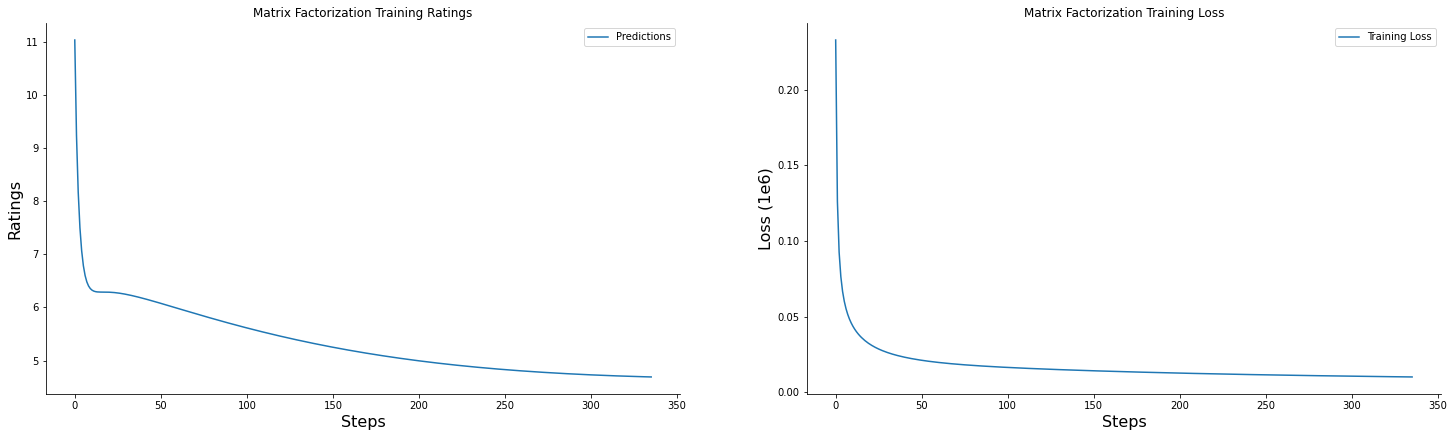

In [ ]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(range(336), predictions_mf, label='Predictions')
# plt.plot(range(50), true_value_mf[-50:], label='True Value')
plt.legend(loc='best')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.xlabel('Steps', fontsize=16)
plt.ylabel('Ratings', fontsize=16)
plt.title('Matrix Factorization Training Ratings')

plt.subplot(2, 2, 2)
plt.plot(range(336), loss_mf, label='Training Loss')
plt.legend(loc='best')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.title('Matrix Factorization Training Loss')
plt.xlabel('Steps', fontsize=16)
plt.ylabel('Loss (1e6)', fontsize=16)
plt.show()

## **Task - 3) Building the Hybrid Recommender System**

In [ ]:
n_users = 944
n_items = 1683

**Loading Ratings Dataset**

In [ ]:
with open("ratings.txt", 'r', encoding='cp1252') as file:
  info = file.read().rstrip('\n')
info

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data = info.split('\n')

dummy = np.zeros((n_items, n_users), dtype=int) # column, rows
user_ = []
movie_ = []

df_ratings = pd.DataFrame(dummy)
df_ratings.head()
for i in range(len(data)):
  obs = data[i].split('\t')
  user_.append(int(obs[0]))
  movie_.append(int(obs[1]))
  df_ratings.iloc[int(obs[1]), int(obs[0])]=int(obs[2])

**Rows = movie ID & Columns = User ID.**

In [ ]:
print(df_ratings.shape)
df_ratings.head()

(1683, 944)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,5,4,0,0,4,4,0,0,0,4,0,0,3,0,1,5,4,5,0,3,5,0,5,0,5,3,0,0,0,0,0,0,0,0,0,0,0,5,0,...,0,0,0,5,0,0,4,0,0,2,0,0,4,3,3,4,0,3,5,3,5,0,0,5,0,3,3,0,4,3,2,3,4,0,4,0,0,5,0,0
2,0,3,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,5
3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0,0,0,3,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
4,0,3,0,0,0,0,0,5,0,0,4,0,5,5,0,0,5,0,3,4,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,0,0,0,0,0,2,0,0,0


**Loading Movies Dataset**

In [ ]:
header = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 
          'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children_s', 
          'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

In [ ]:
df_movies = pd.read_csv('movies.txt', 
                 sep="|",names=header)

In [ ]:
print(df_movies.shape)
df_movies.tail()

(1682, 24)


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_movies['movie_id'].nunique()

1682

In [ ]:
df_tweets_sentiment = pd.read_csv(final_movies_df_csv)

In [ ]:
print(df_tweets_sentiment.shape)
df_tweets_sentiment.head()

(1682, 28)


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,Tweets,hashtags,Sentiment_Score,Sentiment
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The little monsters in the anime story are so...,#ToyStory,1.00,Positive
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,#GoldenEye Multiplayer Daily Totals \n\n0 Use...,#GoldenEye,1.00,Positive
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,@paperbuddha #FourRooms is one of it 🤘,#FourRooms,0.00,Neutral
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,#Mini not quite #quirky enough? How about a #...,#GetShorty,0.49,Positive
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,"“Hey, Ernie! You think there’s any truth to ...",#Copycat,1.00,Positive


###**Merging datasets:** 

- Rantings

- Genre

- Sentiments

In [ ]:
df2 = df_tweets_sentiment.drop(['movie_title','release_date','video_release_date','IMDb_URL','Tweets','hashtags','Sentiment'],axis=1)

In [ ]:
df2.head()

,movie_id,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,Sentiment_Score
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.00
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.00
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.49
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1.00


In [ ]:
# Default inner join
df_merged = pd.merge(df2, df_ratings, left_index=True, right_index=True)

In [ ]:
print(df_merged.shape)
df_merged.head()

(1682, 965)


,movie_id,unknown,Action,Adventure,Animation,Children_s,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,Sentiment_Score,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.00,0,5,4,0,0,4,4,0,0,0,4,0,0,3,0,1,5,4,5,...,0,0,0,5,0,0,4,0,0,2,0,0,4,3,3,4,0,3,5,3,5,0,0,5,0,3,3,0,4,3,2,3,4,0,4,0,0,5,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.00,0,3,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,5
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.49,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0,0,0,3,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1.00,0,3,0,0,0,0,0,5,0,0,4,0,5,5,0,0,5,0,3,...,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,0,0,0,0,0,2,0,0,0


In [ ]:
n_users = 965
n_items = 1682

### **Hybrid Recommender using PyTorch**

**NCF Embedding Layers**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)

        self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=1, kernel_size=1)  
      
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(1, 16, 1)             # 1 input dimensions, 16 target/activation function, 1 filter size
        self.fc1 = torch.nn.Linear(32*20, 128)             # Fully connected layer 1
        self.fc2 = torch.nn.Linear(128, 64)                # Fully connected layer 2
        self.fc3 = torch.nn.Linear(64, 1)                  # Fully connected layer,with output dimension = 1


    def forward(self, user, item):
      user = self.user_factors(user) 
      item = self.item_factors(item)

      user = [t.detach().numpy() for t in user]
      item = [t.detach().numpy() for t in item]

      input_val = torch.LongTensor([user, item])

      input_val = torch.unsqueeze(input_val.long(), dim=1) 
      input_val = torch.tensor(input_val,dtype=torch.float)
      x = F.relu(self.conv1(input_val))
      
      x = F.relu(self.conv2(x))
      x = x.view( -1,32*20)             # Flatten-> 640
      x = F.relu(self.fc1(x))           #-> n, 128
      x = F.relu(self.fc2(x))           #-> n, 64
      x = F.relu(self.fc3(x))           #-> n, 1 (Output dimension)

      return x

In [ ]:
model = MatrixFactorization(n_items, n_users)#, n_factors=20)

In [ ]:
loss_func = torch.nn.MSELoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)  # learning rate

In [ ]:
results = df_merged.to_numpy()

In [ ]:
loss_hybrid=[]
rmse_hybrid_list = []
predictions_hybrid = []
true_value_hybrid = []
hybrid_mse = 0
hybrid_rmse = 0

In [ ]:
rows, cols = results.nonzero()
p = np.random.permutation(len(rows))
rows, cols = rows[p], cols[p]

loss=[]
predictions = []
true_value = []

step = 0
for row, col in zip(*(rows, cols)):
    # Set gradients to zero
    optimizer.zero_grad()
    true_value.append(results[row, col])
    # Turn data into tensors
    rating = torch.FloatTensor([results[row, col]])
    
    row = torch.LongTensor([row])
    col = torch.LongTensor([col])

    # Predict and calculate loss
    prediction_ = model(row, col)
    
    predictions.append(float(prediction_))

    loss_ = loss_func(prediction_, rating)
    loss.append(float(loss_))

    # Backpropagate
    loss_.backward()

    rmse = math.sqrt(float(loss_))

    loss_hybrid.append(float(loss_))
    rmse_hybrid_list.append(float(rmse))
    predictions_hybrid.append(float(prediction_))
    true_value_hybrid.append(float(rating))
    hybrid_mse = float(loss_)
    hybrid_rmse = float(rmse)

    print(' STEP ===>',step,'; MSE:',round(float(loss_),5), '; RMSE:',round(rmse,5))
    
    # Update the parameters
    step+=1
    optimizer.step()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
 STEP ===> 100590 ; MSE: 1.0 ; RMSE: 1.0
 STEP ===> 100591 ; MSE: 9.0 ; RMSE: 3.0
 STEP ===> 100592 ; MSE: 1.0 ; RMSE: 1.0
 STEP ===> 100593 ; MSE: 4.0 ; RMSE: 2.0
 STEP ===> 100594 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100595 ; MSE: 9.0 ; RMSE: 3.0
 STEP ===> 100596 ; MSE: 1.0 ; RMSE: 1.0
 STEP ===> 100597 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100598 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100599 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100600 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100601 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100602 ; MSE: 25.0 ; RMSE: 5.0
 STEP ===> 100603 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100604 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100605 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100606 ; MSE: 9.0 ; RMSE: 3.0
 STEP ===> 100607 ; MSE: 9.0 ; RMSE: 3.0
 STEP ===> 100608 ; MSE: 9.0 ; RMSE: 3.0
 STEP ===> 100609 ; MSE: 9.0 ; RMSE: 3.0
 STEP ===> 100610 ; MSE: 25.0 ; RMSE: 5.0
 STEP ===> 100611 ; MSE: 16.0 ; RMSE: 4.0
 STEP ===> 100612 ; MSE: 1.0 ; RMSE

In [ ]:
# accuracy = accuracy_score(true_value_hybrid, predictions_hybrid)
# print('Accuracy: %f' % accuracy)
# precision = precision_score(true_value_hybrid, predictions_hybrid)
# print('Precision: %f' % precision)
# recall = recall_score(true_value_hybrid, predictions_hybrid)
# print('Recall: %f' % recall)
# f1 = f1_score(testy, yhat_classes)

In [ ]:
results_df.loc[len(results_df.index)] = ['Hybrid', 0, round(loss_hybrid[-1],5), round(math.sqrt(loss_hybrid[-1]),5), 0, 0, 0] 

In [ ]:
model.eval()

MatrixFactorization(
  (user_factors): Embedding(1682, 20, sparse=True)
  (item_factors): Embedding(965, 20, sparse=True)
  (conv1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

**Saving the Model**

In [ ]:
torch.save(model.state_dict(), 'Models/NCfModel.pth')

**Plotting the last 100 Steps**

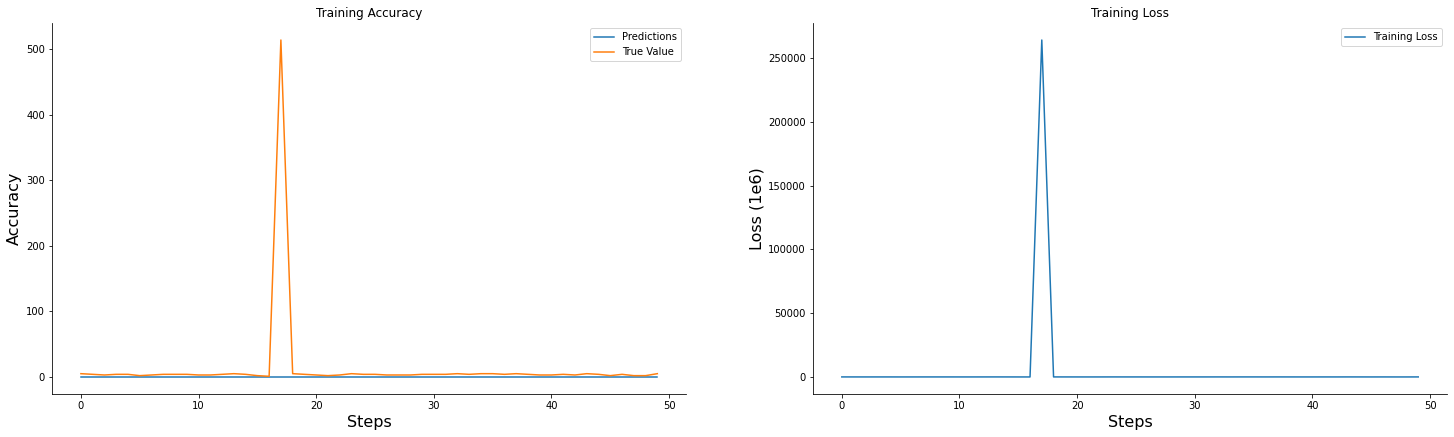

In [ ]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(range(50), predictions_hybrid[-50:], label='Predictions')
plt.plot(range(50), true_value_hybrid[-50:], label='True Value')
plt.legend(loc='best')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.xlabel('Steps', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
#plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(range(50), loss_hybrid[-50:], label='Training Loss')
plt.legend(loc='best')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.title('Training Loss')
plt.xlabel('Steps', fontsize=16)
plt.ylabel('Loss (1e6)', fontsize=16)
plt.show()

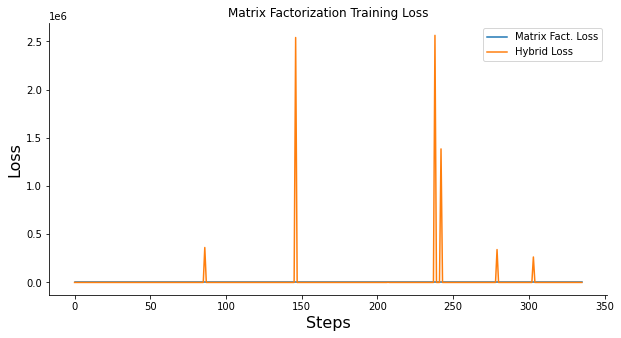

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(336), loss_mf, label='Matrix Fact. Loss')
plt.plot(range(336), loss_hybrid[-336:], label='Hybrid Loss')
plt.legend(loc='best')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.title('Matrix Factorization Training Loss')
plt.xlabel('Steps', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [ ]:
results_df

,System,Accuracy,MSE,RMSE,Precision,Recall,F1-Score
0,Matrix Factorization,0,0.01,0.09998,0,0,0
1,Hybrid,0,25.00,5.00000,0,0,0
